In [1]:
import numpy as np
import scipy.integrate as sc
import matplotlib.pyplot as plt

In [2]:
def m_t(t,m,lmbd,delta,fstar,phi):
    return m+delta*lmbd/(fstar)*np.sin(t+phi)

In [3]:
def PSI_system(v,t,m,S2,theta,gm,lmbd,delta,fstar,phi):
    psi, D = v
    A0 = -S2/(theta*(1+S2))*(m+(1-gm)/theta)
    A1 = m+(S2)*(theta*(1+S2))**(-1)
    dpsidt = (A0-A1*m_t(t,m,lmbd,delta,fstar,phi))*D 
    dDdt = (1+m_t(t,m,lmbd,delta,fstar,phi)**2)**(-1)*psi 
    return [dpsidt, dDdt]

In [41]:
def floquet_analysis_generator(S,gamma_set):
    N2 = S**2*1e-8/1e-4
    theta = 0.01 
    f = 1e-4
    phi = np.pi/2
    S2 = N2*theta**2/f**2
    beta = (1+S2)**(0.5)
    fstar = f*beta
    if gamma_set == "gamma_u":
        gm = 1/(1+S2)
    elif gamma_set == "gamma_m":
        gm = 0.5*(1/(1+S2)+(3-S2)/(3*(1+S2)))
    elif gamma_set == "gamma_l":
        gm = (3-S2)/(3*(1+S2))
    delta = 0.5
    lmbd = N2*theta*gm/f
    n = fstar/lmbd
    Ri = N2*(1-gm)/lmbd**2
    alpha = (1-gm)/gm
    m = np.arange(-200, 200+1, 1)
    frequencies = []
    growth_rates = []
    tau = 2*np.pi
    dt = 100
    for i in m:
        t = np.linspace(0,tau+1/dt,dt)
        sol1 = sc.odeint(PSI_system,[1,0],t,args=(i,S2,theta,gm,lmbd,delta,fstar,phi))
        sol2 = sc.odeint(PSI_system,[0,1],t,args=(i,S2,theta,gm,lmbd,delta,fstar,phi))
        M = np.array([[sol1[-1,0],sol1[-1,1]],[sol2[-1,0],sol2[-1,1]]])
        eigs = np.log(np.linalg.eig(M)[0]+0*1j)/(tau)
        growth_rates.append(eigs.real)
        frequencies.append(eigs.imag)
    frequencies = np.array(frequencies)
    growth_rates = np.array(growth_rates)
    gr = growth_rates[np.argmax(np.abs(growth_rates[:,0])),:]
    fr = frequencies[np.argmax(np.abs(growth_rates[:,0])),:]
    m_max = m[np.argmax(np.abs(growth_rates[:,0]))]
    mean_angle =  -(1-gm)/(theta)
    return growth_rates, frequencies, gr, fr, m_max, mean_angle
    

In [42]:
def TKE_and_velocities(S,gamma_set,m_max,tf):
    N2 = S**2*1e-8/1e-4
    theta = 0.01 
    f = 1e-4
    phi = np.pi/2
    S2 = N2*theta**2/f**2
    beta = (1+S2)**(0.5)
    fstar = f*beta
    if gamma_set == "gamma_u":
        gm = 1/(1+S2)
    elif gamma_set == "gamma_m":
        gm = 0.5*(1/(1+S2)+(3-S2)/(3*(1+S2)))
    elif gamma_set == "gamma_l":
        gm = (3-S2)/(3*(1+S2))
    delta = 0.5
    lmbd = N2*theta*gm/f
    n = fstar/lmbd
    Ri = N2*(1-gm)/lmbd**2
    alpha = (1-gm)/gm
    frequencies = []
    growth_rates = []
    dt = 0.01
    t = np.arange(0,2*np.pi*tf+dt,dt)
    dt = 100
    output = sc.odeint(PSI_system,[0,1],t,args=(m_max,S2,theta,gm,lmbd,delta,fstar,phi))
    w = ((m_t(t,m_max,lmbd,delta,fstar,phi))**2+1)**(-1)*output[:,0]
    u = m_t(t,m_max,lmbd,delta,fstar,phi)*w*n
    v = -f*(gm*S2/theta-theta+m_max)*output[:,1]/lmbd
    b = -theta*(m_max+(1-gm)/theta)*output[:,1]/(1-gm)
    ke = 0.5*(u**2+v**2+n**2*w**2)
    dkdt = np.gradient(ke,t[-1]-t[-2])
    GSP = -v*w
    WSP = -u*w*delta*np.cos(t+np.pi/2)+v*w*(f*np.cos(theta)*delta/fstar*np.sin(t+np.pi/2))
    BFLUX = alpha*beta**(-1)*u*b+w*b*Ri
    error = dkdt-GSP[:]-WSP[:]-BFLUX[:]
    intGSP = sc.cumulative_trapezoid(GSP[:],t[:])
    intWSP = sc.cumulative_trapezoid(WSP[:],t[:])
    intBFLUX = sc.cumulative_trapezoid(BFLUX[:],t[:])
    return t, [u, v, w, b], [dkdt, GSP, WSP, BFLUX], [ke, intGSP, intWSP, intBFLUX]

In [45]:
grwth_S1_u, frqncy_S1_u, gr_max_S1_u, fr_max_S1_u, m_max_S1_u, mean_angle_S1_u = floquet_analysis_generator(1,"gamma_u")
time_S1_u, vels_S1_u, TKE_tends_S1_u, TKE_int_S1_u = TKE_and_velocities(1,"gamma_u",m_max_S1_u,10)

In [46]:
grwth_S1_m, frqncy_S1_m, gr_max_S1_m, fr_max_S1_m, m_max_S1_m, mean_angle_S1_m = floquet_analysis_generator(1,"gamma_m")
time_S1_m, vels_S1_m, TKE_tends_S1_m, TKE_int_S1_m = TKE_and_velocities(1,"gamma_m",m_max_S1_m,6)

In [47]:
grwth_S1_l, frqncy_S1_l, gr_max_S1_l, fr_max_S1_l, m_max_S1_l, mean_angle_S1_l = floquet_analysis_generator(1,"gamma_l")
time_S1_l, vels_S1_l, TKE_tends_S1_l, TKE_int_S1_l = TKE_and_velocities(1,"gamma_l",m_max_S1_l,6)

In [48]:
grwth_S05_u, frqncy_S05_u, gr_max_S05_u, fr_max_S05_u, m_max_S05_u, mean_angle_S05_u = floquet_analysis_generator(0.5,"gamma_u")
time_S05_u, vels_S05_u, TKE_tends_S05_u, TKE_int_S05_u = TKE_and_velocities(0.5,"gamma_u",m_max_S05_u,6)

In [49]:
grwth_S05_m, frqncy_S05_m, gr_max_S05_m, fr_max_S05_m, m_max_S05_m, mean_angle_S05_m = floquet_analysis_generator(0.5,"gamma_m")
time_S05_m, vels_S05_m, TKE_tends_S05_m, TKE_int_S05_m = TKE_and_velocities(0.5,"gamma_m",m_max_S05_m,6)

In [50]:
grwth_S05_l, frqncy_S05_l, gr_max_S05_l, fr_max_S05_l, m_max_S05_l, mean_angle_S05_l = floquet_analysis_generator(0.5,"gamma_l")
time_S05_l, vels_S05_l, TKE_tends_S05_l, TKE_int_S05_l = TKE_and_velocities(0.5,"gamma_l",m_max_S05_l,6)

In [51]:
grwth_S15_u, frqncy_S15_u, gr_max_S15_u, fr_max_S15_u, m_max_S15_u, mean_angle_S15_u = floquet_analysis_generator(1.5,"gamma_u")
time_S15_u, vels_S15_u, TKE_tends_S15_u, TKE_int_S15_u = TKE_and_velocities(1.5,"gamma_u",m_max_S05_u,6)

In [65]:
grwth_S15_m, frqncy_S15_m, gr_max_S15_m, fr_max_S15_m, m_max_S15_m, mean_angle_S15_m = floquet_analysis_generator(1.5,"gamma_m")
time_S15_m, vels_S15_m, TKE_tends_S15_m, TKE_int_S15_m = TKE_and_velocities(1.5,"gamma_m",m_max_S05_m,6)

In [52]:
grwth_S15_l, frqncy_S15_l, gr_max_S15_l, fr_max_S15_l, m_max_S15_l, mean_angle_S15_l = floquet_analysis_generator(1.5,"gamma_l")
time_S15_l, vels_S15_l, TKE_tends_S15_l, TKE_int_S15_l = TKE_and_velocities(1.5,"gamma_l",m_max_S05_l,6)

In [53]:
grwth_S2_u, frqncy_S2_u, gr_max_S2_u, fr_max_S2_u, m_max_S2_u, mean_angle_S2_u = floquet_analysis_generator(2,"gamma_u")
time_S2_u, vels_S2_u, TKE_tends_S2_u, TKE_int_S2_u = TKE_and_velocities(2,"gamma_u",m_max_S2_u,4)

In [55]:
grwth_S2_m, frqncy_S2_m, gr_max_S2_m, fr_max_S2_m, m_max_S2_m, mean_angle_S2_m = floquet_analysis_generator(2,"gamma_m")
time_S2_m, vels_S2_m, TKE_tends_S2_m, TKE_int_S2_m = TKE_and_velocities(2,"gamma_m",m_max_S2_m,4)

In [56]:
grwth_S2_l, frqncy_S2_l, gr_max_S2_l, fr_max_S2_l, m_max_S2_l, mean_angle_S2_l = floquet_analysis_generator(2,"gamma_l")
time_S2_l, vels_S2_l, TKE_tends_S2_l, TKE_int_S2_l = TKE_and_velocities(2,"gamma_l",m_max_S2_l,4)

In [57]:
grwth_S01_u, frqncy_S01_u, gr_max_S01_u, fr_max_S01_u, m_max_S01_u, mean_angle_S01_u = floquet_analysis_generator(0.1,"gamma_u")
time_S01_u, vels_S01_u, TKE_tends_S01_u, TKE_int_S01_u = TKE_and_velocities(0.1,"gamma_u",m_max_S01_u,4)

In [63]:
grwth_S01_m, frqncy_S01_m, gr_max_S01_m, fr_max_S01_m, m_max_S01_m, mean_angle_S01_m = floquet_analysis_generator(0.1,"gamma_m")
time_S01_m, vels_S01_m, TKE_tends_S01_m, TKE_int_S01_m = TKE_and_velocities(0.1,"gamma_m",m_max_S01_m,4)

In [58]:
grwth_S01_l, frqncy_S01_l, gr_max_S01_l, fr_max_S01_l, m_max_S01_l, mean_angle_S01_l = floquet_analysis_generator(0.1,"gamma_l")
time_S01_l, vels_S01_l, TKE_tends_S01_l, TKE_int_S01_l = TKE_and_velocities(0.1,"gamma_l",m_max_S01_l,4)

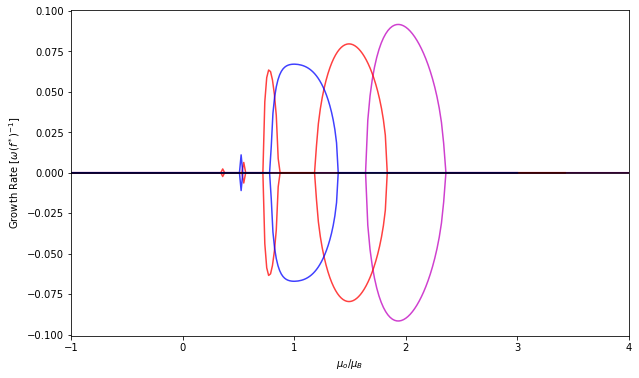

In [59]:
m = np.arange(-200, 200+1, 1)
transparency = 0.75
plt.plot(m/mean_angle_S1_u,np.abs(grwth_S1_u[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S1_u,-1*np.abs(grwth_S1_u[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S1_m,np.abs(grwth_S1_m[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S1_m,-1*np.abs(grwth_S1_m[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S1_l,np.abs(grwth_S1_l[:,0]),color="b",alpha=transparency,zorder=2)
plt.plot(m/mean_angle_S1_l,-1*np.abs(grwth_S1_l[:,0]),color="b",alpha=transparency,zorder=2)
plt.hlines(0,-4,4,zorder=3,color="k")
plt.xlim([-1,4])
plt.xlabel(r"$\mu_o / \mu_{B}$")
plt.ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
# plt.savefig("Floquet_exponent.jpeg")
plt.show()

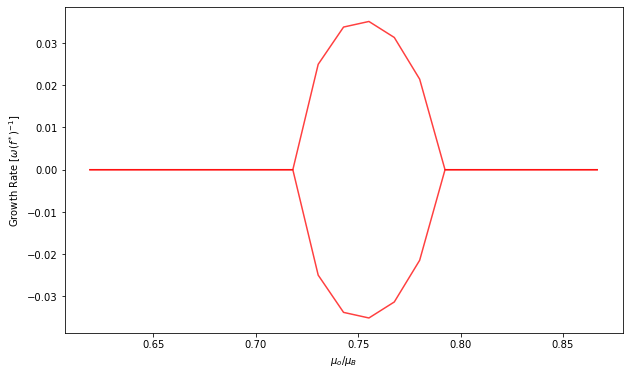

In [84]:
transparency = 0.75
ts = 130
tf = -250
plt.plot(m[ts:tf]/mean_angle_S15_m,np.abs(grwth_S15_m[ts:tf,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m[ts:tf]/mean_angle_S15_m,-1*np.abs(grwth_S15_m[ts:tf,0]),color="r",alpha=transparency,zorder=1)
# plt.hlines(0,-4,4,zorder=3,color="k")
# plt.xlim([-1,4])
plt.xlabel(r"$\mu_o / \mu_{B}$")
plt.ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
# plt.savefig("Floquet_exponent.jpeg")
plt.show()

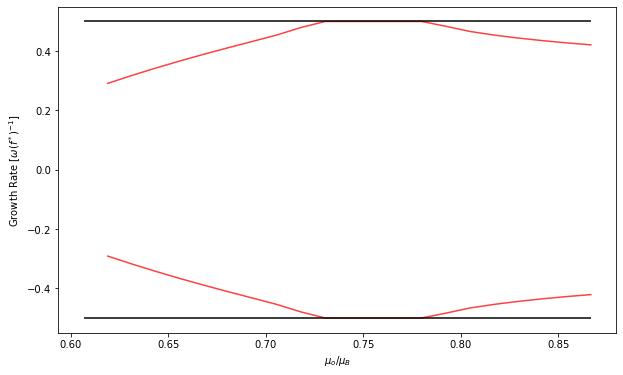

In [91]:
m = np.arange(-200, 200+1, 1)
transparency = 0.75
plt.plot(m[ts:tf]/mean_angle_S15_m,np.abs(frqncy_S15_m[ts:tf,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m[ts:tf]/mean_angle_S15_m,-1*np.abs(frqncy_S15_m[ts:tf,0]),color="r",alpha=transparency,zorder=1)
plt.hlines(0.5,m[ts]/mean_angle_S15_m,m[tf]/mean_angle_S15_m,zorder=3,color="k")
plt.hlines(-0.5,m[ts]/mean_angle_S15_m,m[tf]/mean_angle_S15_m,zorder=3,color="k")

# plt.xlim([-1,4])
plt.xlabel(r"$\mu_o / \mu_{B}$")
plt.ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
# plt.savefig("Floquet_exponent.jpeg")
plt.show()

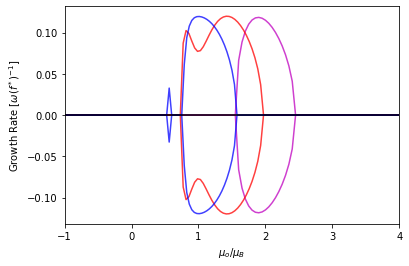

In [30]:
transparency = 0.75
plt.plot(m/mean_angle_S05_u,np.abs(grwth_S05_u[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S05_u,-1*np.abs(grwth_S05_u[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S05_m,np.abs(grwth_S05_m[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S05_m,-1*np.abs(grwth_S05_m[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S05_l,np.abs(grwth_S05_l[:,0]),color="b",alpha=transparency,zorder=2)
plt.plot(m/mean_angle_S05_l,-1*np.abs(grwth_S05_l[:,0]),color="b",alpha=transparency,zorder=2)
plt.hlines(0,-4,4,zorder=3,color="k")
plt.xlim([-1,4])
plt.xlabel(r"$\mu_o / \mu_{B}$")
plt.ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
# plt.savefig("Floquet_exponent.jpeg")
# plt.xscale("symlog",linthresh=0.1)
plt.show()

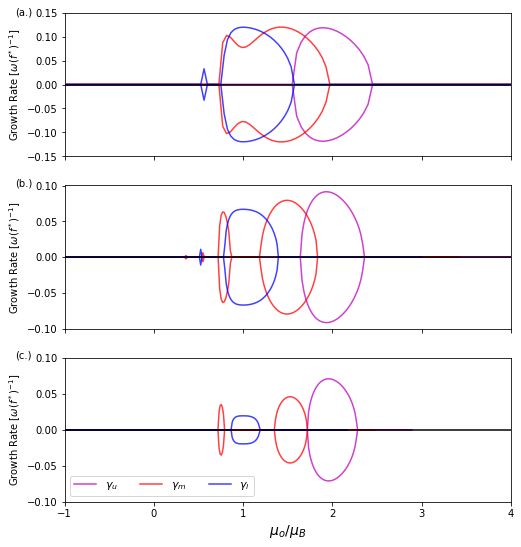

In [31]:
fig, axes = plt.subplots(3, 1,sharex=True,figsize=(8,9))

axes[0].plot(m/mean_angle_S05_u,np.abs(grwth_S05_u[:,0]),color="m",label=r"$\gamma_u$",alpha=transparency,zorder=0)
axes[0].plot(m/mean_angle_S05_u,-1*np.abs(grwth_S05_u[:,0]),color="m",alpha=transparency,zorder=0)
axes[0].plot(m/mean_angle_S05_m,np.abs(grwth_S05_m[:,0]),color="r",label=r"$\gamma_m$",alpha=transparency,zorder=1)
axes[0].plot(m/mean_angle_S05_m,-1*np.abs(grwth_S05_m[:,0]),color="r",alpha=transparency,zorder=1)
axes[0].plot(m/mean_angle_S05_l,np.abs(grwth_S05_l[:,0]),color="b",label=r"$\gamma_l$",alpha=transparency,zorder=2)
axes[0].plot(m/mean_angle_S05_l,-1*np.abs(grwth_S05_l[:,0]),color="b",alpha=transparency,zorder=2)
axes[0].hlines(0,-4,4,zorder=3,color="k")
axes[0].set_xlim([-1,4])
axes[0].set_ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
axes[0].set_yticks(np.arange(-0.15,0.16,0.05))
axes[0].text(-1.55,0.145,"(a.)")

axes[1].plot(m/mean_angle_S1_u,np.abs(grwth_S1_u[:,0]),color="m",label=r"$\gamma_u$",alpha=transparency,zorder=0)
axes[1].plot(m/mean_angle_S1_u,-1*np.abs(grwth_S1_u[:,0]),color="m",alpha=transparency,zorder=0)
axes[1].plot(m/mean_angle_S1_m,np.abs(grwth_S1_m[:,0]),color="r",label=r"$\gamma_m$",alpha=transparency,zorder=1)
axes[1].plot(m/mean_angle_S1_m,-1*np.abs(grwth_S1_m[:,0]),color="r",alpha=transparency,zorder=1)
axes[1].plot(m/mean_angle_S1_l,np.abs(grwth_S1_l[:,0]),color="b",label=r"$\gamma_l$",alpha=transparency,zorder=2)
axes[1].plot(m/mean_angle_S1_l,-1*np.abs(grwth_S1_l[:,0]),color="b",alpha=transparency,zorder=2)
axes[1].hlines(0,-4,4,zorder=3,color="k")
axes[1].set_xlim([-1,4])
axes[1].set_ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
axes[1].set_yticks(np.arange(-0.1,0.11,0.05))
axes[1].text(-1.55,0.1,"(b.)")

axes[2].plot(m/mean_angle_S15_u,np.abs(grwth_S15_u[:,0]),color="m",label=r"$\gamma_u$",alpha=transparency,zorder=0)
axes[2].plot(m/mean_angle_S15_u,-1*np.abs(grwth_S15_u[:,0]),color="m",alpha=transparency,zorder=0)
axes[2].plot(m/mean_angle_S15_m,np.abs(grwth_S15_m[:,0]),color="r",label=r"$\gamma_m$",alpha=transparency,zorder=1)
axes[2].plot(m/mean_angle_S15_m,-1*np.abs(grwth_S15_m[:,0]),color="r",alpha=transparency,zorder=1)
axes[2].plot(m/mean_angle_S15_l,np.abs(grwth_S15_l[:,0]),color="b",label=r"$\gamma_l$",alpha=transparency,zorder=2)
axes[2].plot(m/mean_angle_S15_l,-1*np.abs(grwth_S15_l[:,0]),color="b",alpha=transparency,zorder=2)
axes[2].hlines(0,-4,4,zorder=3,color="k")
axes[2].set_xlim([-1,4])
axes[2].set_xlabel(r"$\mu_o / \mu_{B}$",fontsize=14)
axes[2].set_ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
axes[2].set_yticks(np.arange(-0.1,0.11,0.05))
axes[2].legend(loc="lower left", ncol=3,fontsize=11)
axes[2].text(-1.55,0.1,"(c.)")

# plt.savefig("Floquet_exponent_var_gamma.pdf")

plt.show()

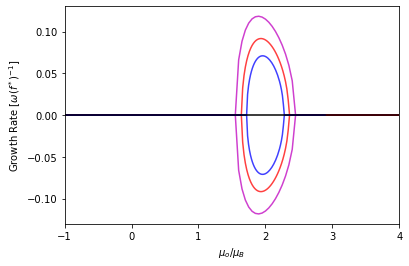

In [32]:
plt.plot(m/mean_angle_S05_u,np.abs(grwth_S05_u[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S05_u,-1*np.abs(grwth_S05_u[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S1_u,np.abs(grwth_S1_u[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S1_u,-1*np.abs(grwth_S1_u[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S15_u,np.abs(grwth_S15_u[:,0]),color="b",alpha=transparency,zorder=2)
plt.plot(m/mean_angle_S15_u,-1*np.abs(grwth_S15_u[:,0]),color="b",alpha=transparency,zorder=2)
plt.hlines(0,-4,4,zorder=3,color="k",alpha=1)
plt.xlim([-1,4])
plt.xlabel(r"$\mu_o / \mu_{B}$")
plt.ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
# plt.savefig("Floquet_exponent.jpeg")
plt.show()

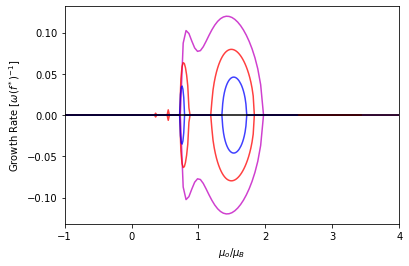

In [33]:
plt.plot(m/mean_angle_S05_m,np.abs(grwth_S05_m[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S05_m,-1*np.abs(grwth_S05_m[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S1_m,np.abs(grwth_S1_m[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S1_m,-1*np.abs(grwth_S1_m[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S15_m,np.abs(grwth_S15_m[:,0]),color="b",alpha=transparency,zorder=2)
plt.plot(m/mean_angle_S15_m,-1*np.abs(grwth_S15_m[:,0]),color="b",alpha=transparency,zorder=2)
plt.hlines(0,-4,4,zorder=3,color="k",alpha=1)
plt.xlim([-1,4])
plt.xlabel(r"$\mu_o / \mu_{B}$")
plt.ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
# plt.savefig("Floquet_exponent.jpeg")
plt.show()

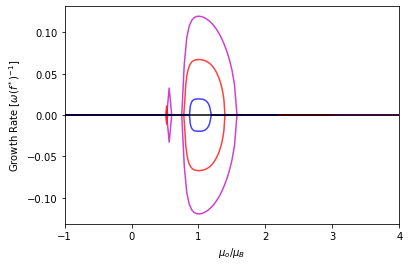

In [34]:
plt.plot(m/mean_angle_S05_l,np.abs(grwth_S05_l[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S05_l,-1*np.abs(grwth_S05_l[:,0]),color="m",alpha=transparency,zorder=0)
plt.plot(m/mean_angle_S1_l,np.abs(grwth_S1_l[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S1_l,-1*np.abs(grwth_S1_l[:,0]),color="r",alpha=transparency,zorder=1)
plt.plot(m/mean_angle_S15_l,np.abs(grwth_S15_l[:,0]),color="b",alpha=transparency,zorder=2)
plt.plot(m/mean_angle_S15_l,-1*np.abs(grwth_S15_l[:,0]),color="b",alpha=transparency,zorder=2)
plt.hlines(0,-4,4,zorder=3,color="k",alpha=1)
plt.xlim([-1,4])
plt.xlabel(r"$\mu_o / \mu_{B}$")
plt.ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
# plt.savefig("Floquet_exponent.jpeg")
plt.show()

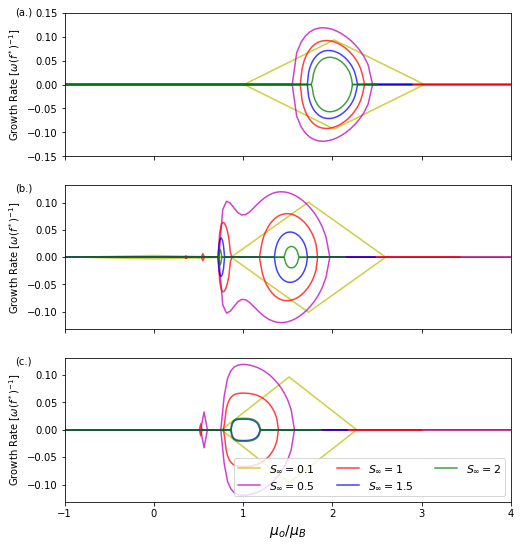

In [35]:
fig, axes = plt.subplots(3, 1,sharex=True,figsize=(8,9))

axes[0].plot(m/mean_angle_S01_u,np.abs(grwth_S01_u[:,0]),color="y",label=r"$\gamma_u$",alpha=transparency,zorder=0)
axes[0].plot(m/mean_angle_S01_u,-1*np.abs(grwth_S01_u[:,0]),color="y",alpha=transparency,zorder=0)
axes[0].plot(m/mean_angle_S05_u,np.abs(grwth_S05_u[:,0]),color="m",label=r"$\gamma_u$",alpha=transparency,zorder=0)
axes[0].plot(m/mean_angle_S05_u,-1*np.abs(grwth_S05_u[:,0]),color="m",alpha=transparency,zorder=0)
axes[0].plot(m/mean_angle_S1_u,np.abs(grwth_S1_u[:,0]),color="r",label=r"$\gamma_m$",alpha=transparency,zorder=1)
axes[0].plot(m/mean_angle_S1_u,-1*np.abs(grwth_S1_u[:,0]),color="r",alpha=transparency,zorder=1)
axes[0].plot(m/mean_angle_S15_u,np.abs(grwth_S15_u[:,0]),color="b",label=r"$\gamma_l$",alpha=transparency,zorder=2)
axes[0].plot(m/mean_angle_S15_u,-1*np.abs(grwth_S15_u[:,0]),color="b",alpha=transparency,zorder=2)
axes[0].plot(m/mean_angle_S2_u,np.abs(grwth_S2_u[:,0]),color="g",label=r"$\gamma_l$",alpha=transparency,zorder=2)
axes[0].plot(m/mean_angle_S2_u,-1*np.abs(grwth_S2_u[:,0]),color="g",alpha=transparency,zorder=2)
# axes[0].hlines(0,-4,4,zorder=3,color="k")
axes[0].set_xlim([-1,4])
axes[0].set_ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
axes[0].set_yticks(np.arange(-0.15,0.16,0.05))
axes[0].text(-1.55,0.145,"(a.)")

axes[1].plot(m/mean_angle_S01_m,np.abs(grwth_S01_m[:,0]),color="y",label=r"$\gamma_u$",alpha=transparency,zorder=0)
axes[1].plot(m/mean_angle_S01_m,-1*np.abs(grwth_S01_m[:,0]),color="y",alpha=transparency,zorder=0)
axes[1].plot(m/mean_angle_S05_m,np.abs(grwth_S05_m[:,0]),color="m",label=r"$\gamma_u$",alpha=transparency,zorder=0)
axes[1].plot(m/mean_angle_S05_m,-1*np.abs(grwth_S05_m[:,0]),color="m",alpha=transparency,zorder=0)
axes[1].plot(m/mean_angle_S1_m,np.abs(grwth_S1_m[:,0]),color="r",label=r"$\gamma_m$",alpha=transparency,zorder=1)
axes[1].plot(m/mean_angle_S1_m,-1*np.abs(grwth_S1_m[:,0]),color="r",alpha=transparency,zorder=1)
axes[1].plot(m/mean_angle_S15_m,np.abs(grwth_S15_m[:,0]),color="b",label=r"$\gamma_l$",alpha=transparency,zorder=2)
axes[1].plot(m/mean_angle_S15_m,-1*np.abs(grwth_S15_m[:,0]),color="b",alpha=transparency,zorder=2)
axes[1].plot(m/mean_angle_S2_m,np.abs(grwth_S2_m[:,0]),color="g",label=r"$\gamma_l$",alpha=transparency,zorder=2)
axes[1].plot(m/mean_angle_S2_m,-1*np.abs(grwth_S2_m[:,0]),color="g",alpha=transparency,zorder=2)
# axes[1].hlines(0,-4,4,zorder=3,color="k")
axes[1].set_xlim([-1,4])
axes[1].set_ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
axes[1].set_yticks(np.arange(-0.1,0.11,0.05))
axes[1].text(-1.55,0.12,"(b.)")

axes[2].plot(m/mean_angle_S01_l,np.abs(grwth_S01_l[:,0]),color="y",label=r"$S_\infty=0.1$",alpha=transparency,zorder=0)
axes[2].plot(m/mean_angle_S01_l,-1*np.abs(grwth_S01_l[:,0]),color="y",alpha=transparency,zorder=0)
axes[2].plot(m/mean_angle_S05_l,np.abs(grwth_S05_l[:,0]),color="m",label=r"$S_\infty=0.5$",alpha=transparency,zorder=0)
axes[2].plot(m/mean_angle_S05_l,-1*np.abs(grwth_S05_l[:,0]),color="m",alpha=transparency,zorder=0)
axes[2].plot(m/mean_angle_S1_l,np.abs(grwth_S1_l[:,0]),color="r",label=r"$S_\infty=1$",alpha=transparency,zorder=1)
axes[2].plot(m/mean_angle_S1_l,-1*np.abs(grwth_S1_l[:,0]),color="r",alpha=transparency,zorder=1)
axes[2].plot(m/mean_angle_S15_l,np.abs(grwth_S15_l[:,0]),color="b",label=r"$S_\infty=1.5$",alpha=transparency,zorder=2)
axes[2].plot(m/mean_angle_S15_l,-1*np.abs(grwth_S15_l[:,0]),color="b",alpha=transparency,zorder=2)
axes[2].plot(m/mean_angle_S2_l,np.abs(grwth_S2_l[:,0]),color="g",label=r"$S_\infty=2$",alpha=transparency,zorder=2)
axes[2].plot(m/mean_angle_S2_l,-1*np.abs(grwth_S2_l[:,0]),color="g",alpha=transparency,zorder=2)
# axes[2].hlines(0,-4,4,zorder=3,color="k")
axes[2].set_xlim([-1,4])
axes[2].set_xlabel(r"$\mu_o / \mu_{B}$",fontsize=14)
axes[2].set_ylabel(R"Growth Rate [$\omega (f^*)^{-1}$]")
axes[2].set_yticks(np.arange(-0.1,0.11,0.05))
axes[2].legend(loc="lower right", ncol=3,fontsize=11)
axes[2].text(-1.55,0.12,"(c.)")

# plt.savefig("Floquet_exponent_var_Sinf.pdf")

plt.show()

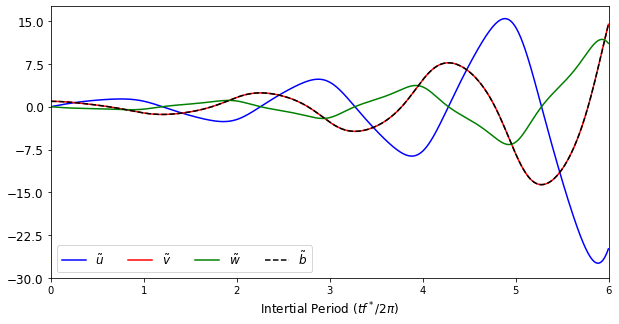

In [36]:
plt.rcParams["figure.figsize"] = (10, 5)
ti = 1256
tf = ti*3
plt.plot(time_S1_u[:tf]/(2*np.pi),np.array(vels_S1_u)[0,:tf],color="blue",label=r"$\tilde{u}$")
plt.plot(time_S1_u[:tf]/(2*np.pi),np.array(vels_S1_u)[1,:tf],color="red",label=r"$\tilde{v}$",alpha=1)
plt.plot(time_S1_u[:tf]/(2*np.pi),np.array(vels_S1_u)[2,:tf],color="g",label=r"$\tilde{w}$")
plt.plot(time_S1_u[:tf]/(2*np.pi),np.array(vels_S1_u)[3,:tf],color="k",linestyle="--",label=r"$\tilde{b}$")
plt.xlabel(r"Intertial Period ($tf^*/2\pi$)",fontsize=12)
plt.legend(loc="lower left",ncol=4,fontsize=12)
plt.xlim([0,6])
plt.yticks(np.arange(-30,20,7.5),fontsize=12)
plt.show()

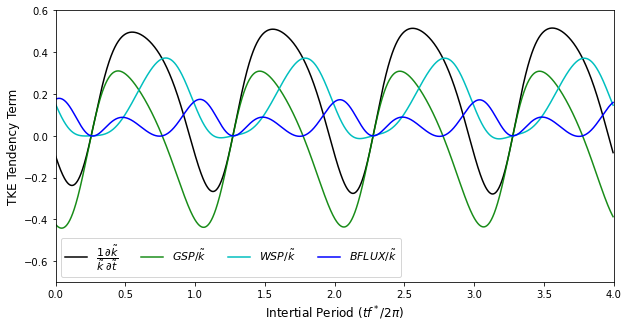

In [37]:
ti = 1256
tf = ti*3
plt.rcParams["figure.figsize"] = (10, 5)
plt.plot((time_S1_u[ti:tf]-time_S1_u[ti])/(2*np.pi),TKE_tends_S1_u[0][ti:tf]/TKE_int_S1_u[0][ti:tf],color="k",label=r"$\dfrac{1}{\tilde{k}}\dfrac{\partial \tilde{k}}{\partial \tilde{t}}$")
plt.plot((time_S1_u[ti:tf]-time_S1_u[ti])/(2*np.pi),TKE_tends_S1_u[1][ti:tf]/TKE_int_S1_u[0][ti:tf],color="g",label=r"$GSP/\tilde{k}$",alpha=0.9)
plt.plot((time_S1_u[ti:tf]-time_S1_u[ti])/(2*np.pi),TKE_tends_S1_u[2][ti:tf]/TKE_int_S1_u[0][ti:tf],color="c",label=r"$WSP/\tilde{k}$")
plt.plot((time_S1_u[ti:tf]-time_S1_u[ti])/(2*np.pi),TKE_tends_S1_u[3][ti:tf]/TKE_int_S1_u[0][ti:tf],color="blue",linestyle="-",label=r"$BFLUX/\tilde{k}$")

plt.xlabel(r"Intertial Period ($tf^*/2\pi$)",fontsize=12)
plt.ylabel(r"TKE Tendency Term",fontsize=12)
plt.legend(loc="lower left",ncol=4,fontsize=11)
plt.xlim([0,4])
plt.ylim([-0.7,0.6])
plt.show()

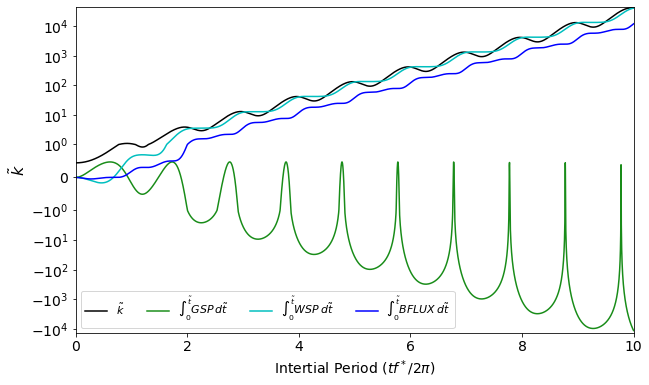

In [38]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.plot((time_S1_u)/(2*np.pi),TKE_int_S1_u[0],color="k",label=r"$\tilde{k}$")
plt.plot((time_S1_u[:-1])/(2*np.pi),TKE_int_S1_u[1],color="g",label=r"$\int_0^{\tilde{t}}GSP\,d\tilde{t}$",alpha=0.9)
plt.plot((time_S1_u[:-1])/(2*np.pi),TKE_int_S1_u[2],color="c",label=r"$\int_0^{\tilde{t}}WSP\,d\tilde{t}$")
plt.plot((time_S1_u[:-1])/(2*np.pi),TKE_int_S1_u[3],color="blue",linestyle="-",label=r"$\int_0^{\tilde{t}}BFLUX\,d\tilde{t}$")
plt.xlabel(r"Intertial Period ($tf^*/2\pi$)",fontsize=14)
plt.ylabel(r"$\tilde{k}$",fontsize=16)
plt.legend(loc="lower left",ncol=4,fontsize=11)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,10])
# plt.ylim([-0.7,0.6])
plt.yscale("symlog",linthresh=1)
plt.show()

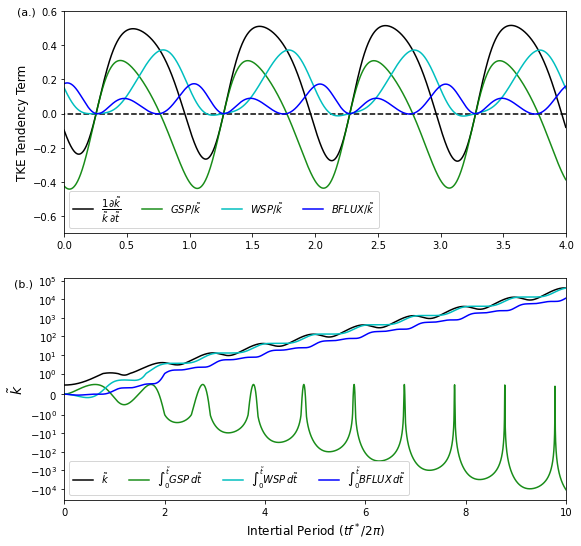

In [39]:
fig, axes = plt.subplots(2, 1,sharex=False,figsize=(9,9))

ti = 1256
tf = ti*3
axes[0].plot((time_S1_u[ti:tf]-time_S1_u[ti])/(2*np.pi),TKE_tends_S1_u[0][ti:tf]/TKE_int_S1_u[0][ti:tf],color="k",label=r"$\dfrac{1}{\tilde{k}}\dfrac{\partial \tilde{k}}{\partial \tilde{t}}$")
axes[0].plot((time_S1_u[ti:tf]-time_S1_u[ti])/(2*np.pi),TKE_tends_S1_u[1][ti:tf]/TKE_int_S1_u[0][ti:tf],color="g",label=r"$GSP/\tilde{k}$",alpha=0.9)
axes[0].plot((time_S1_u[ti:tf]-time_S1_u[ti])/(2*np.pi),TKE_tends_S1_u[2][ti:tf]/TKE_int_S1_u[0][ti:tf],color="c",label=r"$WSP/\tilde{k}$")
axes[0].plot((time_S1_u[ti:tf]-time_S1_u[ti])/(2*np.pi),TKE_tends_S1_u[3][ti:tf]/TKE_int_S1_u[0][ti:tf],color="blue",linestyle="-",label=r"$BFLUX/\tilde{k}$")
axes[0].hlines(0,4,0,color="k",linestyle="--")
axes[0].set_ylabel(r"TKE Tendency Term",fontsize=12)
axes[0].legend(loc="lower left",ncol=4)
axes[0].text(-0.375,0.58,"(a.)",fontsize=11)
axes[0].set_xlim([0,4])
axes[0].set_ylim([-0.7,0.6])

axes[1].plot((time_S1_u)/(2*np.pi),TKE_int_S1_u[0],color="k",label=r"$\tilde{k}$")
axes[1].plot((time_S1_u[:-1])/(2*np.pi),TKE_int_S1_u[1],color="g",label=r"$\int_0^{\tilde{t}}GSP\,d\tilde{t}$",alpha=0.9)
axes[1].plot((time_S1_u[:-1])/(2*np.pi),TKE_int_S1_u[2],color="c",label=r"$\int_0^{\tilde{t}}WSP\,d\tilde{t}$")
axes[1].plot((time_S1_u[:-1])/(2*np.pi),TKE_int_S1_u[3],color="blue",linestyle="-",label=r"$\int_0^{\tilde{t}}BFLUX\,d\tilde{t}$")
axes[1].set_xlabel(r"Intertial Period ($tf^*/2\pi$)",fontsize=12)
axes[1].set_ylabel(r"$\tilde{k}$",fontsize=14)
axes[1].legend(loc="lower left",ncol=4)
axes[1].text(-1,0.5e5,"(b.)",fontsize=11)
axes[1].set_xlim([0,10])
axes[1].set_yscale("symlog",linthresh=1)

plt.savefig("TKE_stability.pdf")

plt.show()